# Binary Classification - N01
Let's repeat the toy classification problem with moon dataset.
We will build a multi-input single-output neural network model with 1 hidden layer.

1. Training
    1. Prepare training dataset
        1. Load raw data.
        2. Rescale and reshape.
    2. Initialize model (with random parameters: w, b).
    3. Evaluate the model with a metric (e.g. BCE).
    4. Calculate gradient of loss.
    5. Update parameters a small step on the directions descending the gradient of loss.
    6. Repeat 3 to 5 until converge.

2. Validation
    1. Prepare validation dataset
        1. Load raw data.
        2. Rescale and reshape.
    2. Evaluate model on validation data with all kinds of metrics.


## Load Raw Data
[scikit-learn](https://scikit-learn.org/stable/index.html) is a handy machine learning library for Python. We can creat an artificial dataset for the binary classification task using its [datasets](https://scikit-learn.org/stable/api/sklearn.datasets.html) module.

In [1]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

features_raw, labels_raw = make_moons(n_samples=1024, noise=0.2, random_state=3321)
print(features_raw.shape, labels_raw.shape)
print(features_raw[:10])
print(labels_raw[:10])

(1024, 2) (1024,)
[[-0.86691851 -0.32027284]
 [ 1.70922817 -0.66094909]
 [ 0.95477398  0.28453102]
 [ 0.14465106  0.33336045]
 [ 0.58070122  0.65058253]
 [ 1.33531488 -0.2647643 ]
 [ 1.46344736 -0.55310411]
 [-1.20787839  0.52778545]
 [ 0.47737585 -0.2020379 ]
 [ 1.45674566 -0.27188258]]
[0 1 0 1 0 1 1 0 1 1]


### Pre-Process Data
1. Standardize features matrix, $X$, using mean and standard deviation of each feature.
$$Z = \frac{X - \mu}{\sigma}$$
2. Reshape label vector.

(1024, 2) (1024, 1)


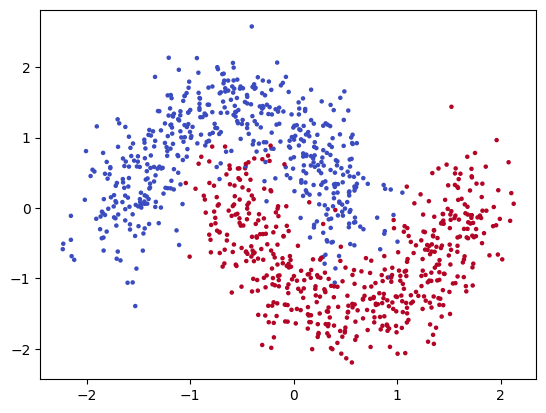

In [2]:
# Rescale by max
features_train = (features_raw - features_raw.mean(axis=0)) / features_raw.std(axis=0)

# Reshape labels
labels_train = labels_raw.reshape(-1, 1)
print(features_train.shape, labels_train.shape)  # for debug

# Visualize
plt.scatter(
    features_train[:, 0], 
    features_train[:, 1], 
    s=5*np.ones(labels_train.size), 
    c=labels_train, 
    cmap='coolwarm'
)

In [3]:
features_raw.mean(axis=0), features_raw.std(axis=0)

(array([0.50105456, 0.23975591]), array([0.87906415, 0.52982808]))

## N11 Model
 
$$
\begin{align*} 
    \hat{\mathbf{y}} &= \sigma(\mathbf{X}^{[1]} \cdot \mathbf{w}^{[2]T} + \mathbf{b}^{[2]}) \\
    &= \sigma(\sigma(\mathbf{X}^{[0]} \cdot \mathbf{W}^{[1]T} + \mathbf{b}^{[1]}) \cdot \mathbf{w}^{[2]T} + \mathbf{b}^{[2]})
\end{align*}
$$

In [4]:
def linear(in_features, weight, bias):
    out_features = in_features @ weight.T + bias
    return out_features

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward(in_features, params):
    features_1 = sigmoid(linear(in_features, params['W1'], params['b1']))
    predictions = sigmoid(linear(features_1, params['W2'], params['b2']))
    return predictions, features_1

# Sanity check
params_dummy = {
    'W1': np.random.normal(size=(8, features_train.shape[1])),
    'b1': np.random.normal(size=(1, 8)),
    'W2': np.random.normal(size=(1, 8)),
    'b2': np.random.normal()
}

preds_dummy, X1_dummy = forward(features_train[:3], params_dummy)
print(preds_dummy)
print(X1_dummy.shape)


[[0.97908351]
 [0.94425748]
 [0.8931913 ]]
(3, 8)


### Visualize Descision Boundary


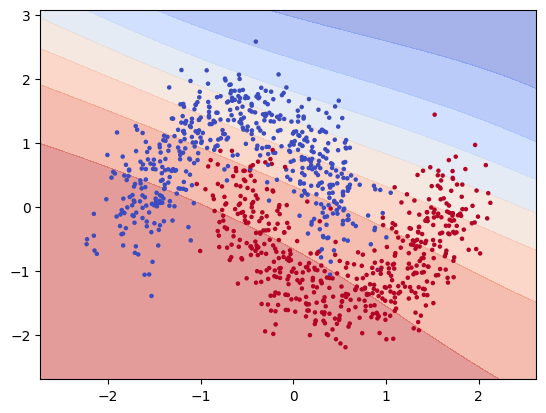

In [5]:
# Plot decision boundary
def plot_decision_boundary(pred_func, features, labels):
    # Set min and max values and give it some padding
    x_min, x_max = features[:, 0].min() - 0.5, features[:, 0].max() + 0.5
    y_min, y_max = features[:, 1].min() - 0.5, features[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.5)
    plt.scatter(
        features[:, 0], 
        features[:, 1], 
        c=labels, 
        s=5*np.ones(labels_train.size), 
        cmap='coolwarm', 
    )

plot_decision_boundary(lambda x: forward(x, params_dummy)[0], features_train, labels_train)

## Model Performance Metrics
### BCE Loss
$\mathcal{L}(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{M} \sum_{i=1}^{M} -{}^{(i)}y \ln {}^{(i)}\hat{y} - (1 - {}^{(i)}y) \ln (1 - {}^{(i)}\hat{y}) = \overline{-\mathbf{y} \ln \hat{\mathbf{y}} - (1 - \mathbf{y}) \ln (1 - \hat{\mathbf{y}})}$

### Accuracy

In [9]:
def bce_loss(preds, labels):
    error = -labels * np.log(preds) - (1 - labels) * np.log(1 - preds)
    return error.mean()

def accuracy(preds, labels):
    preds_binary = (preds >= 0.5).astype(int)
    return (preds_binary == labels).mean()

# Sanity check
print(f"BCE Loss: {bce_loss(preds_dummy, labels_train[:3])}, Accuracy: {accuracy(preds_dummy, labels_train[:3])}")


BCE Loss: 2.0537632433089357, Accuracy: 0.3333333333333333


## Gradients of Loss
$$\frac{\partial \mathcal{L}}{\partial \mathbf{w}^{[2]}} = \frac{1}{M} (\mathbf{\hat{y}} - \mathbf{y})^T \cdot \mathbf{X}^{[1]}$$

$$\frac{\partial \mathcal{L}}{\partial b^{[2]}} = \overline{(\mathbf{\hat{y}} - \mathbf{y})}$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} = (\mathbf{\hat{y}} - \mathbf{y})^T \cdot \mathbf{w}^{[2]}$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} = \frac{1}{M} [(\mathbf{\hat{y}} - \mathbf{y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]})]^T \cdot \mathbf{X}^{[0]}$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{[1]}} = \overline{
    (\mathbf{\hat{y}} - \mathbf{y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]})
} \text{, on 1st dimension}
$$


In [8]:
def grads(in_features, features_1, predictions, labels, params):
    M = labels.shape[0]
    dL_dW2 = (predictions - labels).T @ features_1 / M
    dL_b2 = (predictions - labels).mean()
    dL_dX1 = (predictions - labels) @ params['W2']
    dL_dW1 = (dL_dX1 * features_1 * (1 - features_1)).T @ in_features / M
    dL_db1 = (dL_dX1 * features_1 * (1 - features_1)).mean(axis=0)
    return {
        'dW2': dL_dW2,
        'db2': dL_b2,
        'dW1': dL_dW1,
        'db1': dL_db1
    }   

# Sanity check
grads_dummy = grads(features_train[:3], X1_dummy, preds_dummy, labels_train[:3], params_dummy)
for k, v in grads_dummy.items():
    print(f"{k}: {v}")    

dW2: [[0.35839114 0.45411934 0.45119386 0.39073867 0.51324725 0.09963244
  0.28299077 0.25762127]]
db2: 0.6055107645200494
dW1: [[-0.00348757 -0.00325749]
 [-0.00357641 -0.00325711]
 [ 0.00398333 -0.00072165]
 [-0.12435313 -0.09649376]
 [-0.02225724 -0.01631281]
 [-0.01337567  0.00240393]
 [ 0.0733194   0.05831873]
 [-0.26426568 -0.1909394 ]]
db1: [ 0.02719695  0.01126281  0.02298769  0.19486961  0.04721242 -0.05656389
 -0.12610012  0.35299781]


## Back-Propagation Parameter Optimization

Iter 0: Train Loss 0.6931471894389096, Train Acc 0.5
Iter 10: Train Loss 0.6931471803654631, Train Acc 0.5
Iter 20: Train Loss 0.6931471728305008, Train Acc 0.5
Iter 30: Train Loss 0.693147163624084, Train Acc 0.5
Iter 40: Train Loss 0.6931471508337876, Train Acc 0.5
Iter 50: Train Loss 0.6931471318109679, Train Acc 0.5
Iter 60: Train Loss 0.693147102614351, Train Acc 0.5
Iter 70: Train Loss 0.693147057190999, Train Acc 0.5
Iter 80: Train Loss 0.6931469861194292, Train Acc 0.5
Iter 90: Train Loss 0.6931468746538088, Train Acc 0.5
Iter 100: Train Loss 0.6931466996631677, Train Acc 0.5
Iter 110: Train Loss 0.6931464248302797, Train Acc 0.5
Iter 120: Train Loss 0.6931459931137094, Train Acc 0.5
Iter 130: Train Loss 0.6931453149086022, Train Acc 0.5
Iter 140: Train Loss 0.6931442494493485, Train Acc 0.6328125
Iter 150: Train Loss 0.6931425755953383, Train Acc 0.7998046875
Iter 160: Train Loss 0.693139945939407, Train Acc 0.8427734375
Iter 170: Train Loss 0.6931358147220754, Train Acc 0.848

(0.0, 1.0)

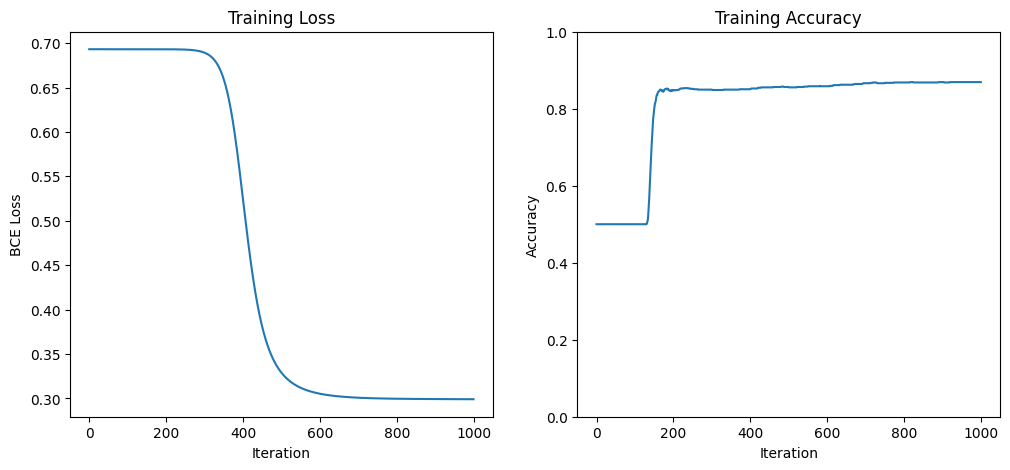

In [13]:
# Optimization iterations
params = {
    'W1': np.random.normal(0, 1e-4, (16, features_train.shape[1])),
    'b1': np.random.normal(0, 1e-4, (1, 16)),
    'W2': np.random.normal(0, 1e-4, (1, 16)),
    'b2': np.random.normal(0, 1e-4)
}
num_iters = 1000
learning_rate = 0.2
losses_train = []
accuracies_train = []

for i in range(num_iters):
    preds_train, features_1_train = forward(features_train, params)
    loss_train = bce_loss(preds_train, labels_train)
    acc_train = accuracy(preds_train, labels_train)
    losses_train.append(loss_train)
    accuracies_train.append(acc_train)

    grads_params = grads(features_train, features_1_train, preds_train, labels_train, params)

    # Gradient descent parameter update
    params['W1'] -= learning_rate * grads_params['dW1']
    params['b1'] -= learning_rate * grads_params['db1']
    params['W2'] -= learning_rate * grads_params['dW2']
    params['b2'] -= learning_rate * grads_params['db2']

    if i % 10 == 0 or i == num_iters - 1:
        print(f"Iter {i}: Train Loss {loss_train}, Train Acc {acc_train}")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("BCE Loss")
plt.subplot(1, 2, 2)
plt.plot(accuracies_train)
plt.title("Training Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(0, 1)



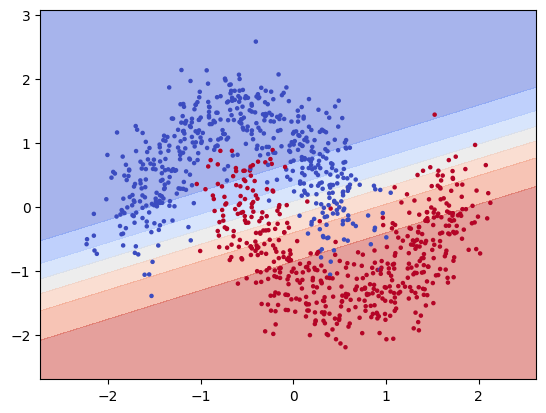

In [14]:
### Visualize Trained Descision Boundary
plot_decision_boundary(lambda x: forward(x, params)[0], features_train, labels_train)